In [1]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [2]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [3]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
dirpath = 'IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
Xstore = X

In [6]:
class PCA:
    def __init__(self):
        self.X = None
        self.U = None
        self.S = None
        self.V = None
    
    def fit(self,X):
        self.X = X
        m, n = X.shape
        row_mean = np.mean(X, axis=1)

        X = X - row_mean[:, np.newaxis]     # Centering the data
        Z = (1.0/np.sqrt(n-1)) * X.T
        covZ = np.dot(Z.T, Z)               # Covariance matrix
        U, S, Vt = np.linalg.svd(covZ)      # SVD of Covariance matrix
        self.U = U
        self.S = S
        self.V = Vt.T
    
    def get_transform(self,n):
        VV = self.V[:, :n]
        Y = np.dot(VV.T, self.X)
        X_reduced = np.dot(VV, Y)
        return X_reduced

    def get_cumulative_variance(self):  
        explained_variance = (self.S ** 2) / np.sum(self.S ** 2)
        cumulative_explained_variance = np.cumsum(explained_variance)
        return cumulative_explained_variance

In [7]:
# 1.1 PCA

X = X.reshape(N,H*W*C)

pca = PCA()
pca.fit(X)

In [8]:
# 1.1.1
# Dimensionality Reduction varying the No. of PCs.
for pc_count in [2, 10, 50, 100, 250, 500, 1000]:
    X_reduced = pca.get_transform(pc_count)
    print('Number of Principal Components =', pc_count)
    print('X[0]\t:', X[0])
    print('X_reduced[0]:', X_reduced[0])
    print()
    # X_reduced = X_reduced.reshape(N,H,W,C)
    # ind = np.random.randint(0,y.shape[0],6)
    # display_images(Xstore[ind,...],y[ind], row=2,col=3)
    # display_images(X_reduced[ind,...],y[ind], row=2,col=3)

Number of Principal Components = 2
X[0]	: [0.00390625 0.         0.         ... 0.859375   0.578125   0.27734375]
X_reduced[0]: [-0.21985208 -0.23569788 -0.23170891 ... -0.09823539 -0.10197204
 -0.10996792]

Number of Principal Components = 10
X[0]	: [0.00390625 0.         0.         ... 0.859375   0.578125   0.27734375]
X_reduced[0]: [0.55624676 0.44310948 0.36134905 ... 0.84722879 0.69284338 0.55185454]

Number of Principal Components = 50
X[0]	: [0.00390625 0.         0.         ... 0.859375   0.578125   0.27734375]
X_reduced[0]: [0.20269815 0.16847994 0.10946161 ... 0.84705752 0.71370284 0.56517314]

Number of Principal Components = 100
X[0]	: [0.00390625 0.         0.         ... 0.859375   0.578125   0.27734375]
X_reduced[0]: [0.28514502 0.28144833 0.24384127 ... 0.9838225  0.81921257 0.63294062]

Number of Principal Components = 250
X[0]	: [0.00390625 0.         0.         ... 0.859375   0.578125   0.27734375]
X_reduced[0]: [0.21212025 0.20632054 0.16767955 ... 1.03351487 0.8086

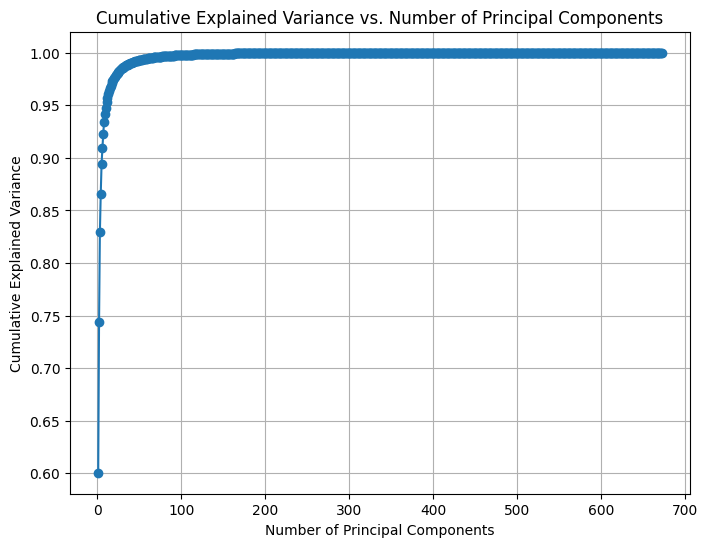

In [9]:
# 1.1.2
cumulative_explained_variance = pca.get_cumulative_variance()

# No. of Principal Components vs Cumulative Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [10]:
# 1.1.3
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score

# from A1
class KNNOptimised:
    def __init__(self, k, distance_metric):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder_type = None
        self.x_train = None
        self.y_train = None
    
    def fit_model(self,x_train,y_train,encoder_type):
        self.x_train = x_train
        self.y_train = y_train
        self.encoder_type = encoder_type
    
    def euclidean_dist(self,x):
        return np.linalg.norm(self.x_train - x, axis=1)
    
    def manhattan_dist(self,x):
        return np.linalg.norm(self.x_train - x, ord=1, axis=1)
    
    def cosine_dist(self,x):
        # A.B = |A|.|B|.Cos(Theta)
        # Cos(Theta) = A.B/(|A|.|B|)
        dot_product = np.dot(self.x_train, x)
        norm_x1 = np.linalg.norm(self.x_train,axis=1)
        norm_x2 = np.linalg.norm(x)
        return 1 - (dot_product / (norm_x1 * norm_x2))
    
    def calc_dist(self,x):
        if(self.distance_metric == "euclidean"):
            return self.euclidean_dist(x)
        
        if(self.distance_metric == "manhattan"):
            return self.manhattan_dist(x)
        
        if(self.distance_metric == "cosine"):
            return self.cosine_dist(x)
        
        return None #invalid distance_metric

    def pred(self,x):
        dist = self.calc_dist(x)
        k_indices = np.argsort(dist)[:self.k]
        k_list = self.y_train[k_indices]    # list of labels with index from k_indices
        label_pred = Counter(k_list).most_common(1)[0][0]
        
        return label_pred
    
    def eval(self,x_test,y_test):
        y_pred = [self.pred(entry) for entry in x_test]
        f1 = f1_score(y_test, y_pred, average='macro',zero_division=0)
        accuracy = 1 - hamming_loss(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
        return f1, accuracy, precision, recall
# from A1 


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import hamming_loss

data = np.load('data.npy', allow_pickle=True)
EMBED_TYPE = 2

labels = data[:, 3]
mat = np.hstack(data[:,EMBED_TYPE])
mat = mat.reshape(-1, 512)
pca3 = PCA()
pca3.fit(mat)

# [Params-(7,VIT,manhattan)]

# Original data metrics
x_train, x_test, y_train, y_test = train_test_split(mat, labels, test_size=0.2, random_state=21)
knn = KNNOptimised(7, "manhattan")
knn.fit_model(x_train, y_train, "VIT")
f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
print("F1 score:", f1)
print("Accuracy:", accuracy_val)
print("Precision:", precision)
print("Recall:", recall)
print()

# Metrics for Reduced Data 
mat_reduced = pca3.get_transform(10)    # top 10 PCs
x_train, x_test, y_train, y_test = train_test_split(mat_reduced, labels, test_size=0.2, random_state=21)
knn = KNNOptimised(7, "manhattan")
knn.fit_model(x_train, y_train, "VIT")
f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
print("F1 score:", f1)
print("Accuracy:", accuracy_val)
print("Precision:", precision)
print("Recall:", recall)

F1 score: 0.17316449175824175
Accuracy: 0.30000000000000004
Precision: 0.16651582792207792
Recall: 0.22342757936507937

F1 score: 0.08233379739403836
Accuracy: 0.14
Precision: 0.07702954675846242
Recall: 0.10589022757697455


In [11]:
# 1.1.4
def get_accuracy(X):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

    knn = KNeighborsClassifier(n_neighbors=13)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    
    hamming = 1 - hamming_loss(y_test, y_pred)
    return hamming

pca3 = PCA()
pca3.fit(X)
max_pc_count = X.shape[1] 
acurracies_pcs = []

for pc_count in range(1,max_pc_count+1):
    X_reduced = pca3.get_transform(pc_count)
    accuracy = get_accuracy(X_reduced)
    acurracies_pcs.append(accuracy)

accuracy_original = get_accuracy(X)
print('Accuracy of original data:', accuracy_original)

for i, accuracy in enumerate(acurracies_pcs):
    print('Accuracy of PCA with', i+1, 'PCs:', accuracy)

Accuracy of original data: 0.37777777777777777
Accuracy of PCA with 1 PCs: 0.2592592592592593
Accuracy of PCA with 2 PCs: 0.28148148148148144
Accuracy of PCA with 3 PCs: 0.37037037037037035
Accuracy of PCA with 4 PCs: 0.3481481481481481
Accuracy of PCA with 5 PCs: 0.4296296296296296
Accuracy of PCA with 6 PCs: 0.36296296296296293
Accuracy of PCA with 7 PCs: 0.3555555555555555
Accuracy of PCA with 8 PCs: 0.3481481481481481
Accuracy of PCA with 9 PCs: 0.37777777777777777
Accuracy of PCA with 10 PCs: 0.33333333333333337
Accuracy of PCA with 11 PCs: 0.3925925925925926
Accuracy of PCA with 12 PCs: 0.3407407407407408
Accuracy of PCA with 13 PCs: 0.32592592592592595
Accuracy of PCA with 14 PCs: 0.33333333333333337
Accuracy of PCA with 15 PCs: 0.3481481481481481
Accuracy of PCA with 16 PCs: 0.3407407407407408
Accuracy of PCA with 17 PCs: 0.32592592592592595
Accuracy of PCA with 18 PCs: 0.3925925925925926
Accuracy of PCA with 19 PCs: 0.4296296296296296
Accuracy of PCA with 20 PCs: 0.42222222222

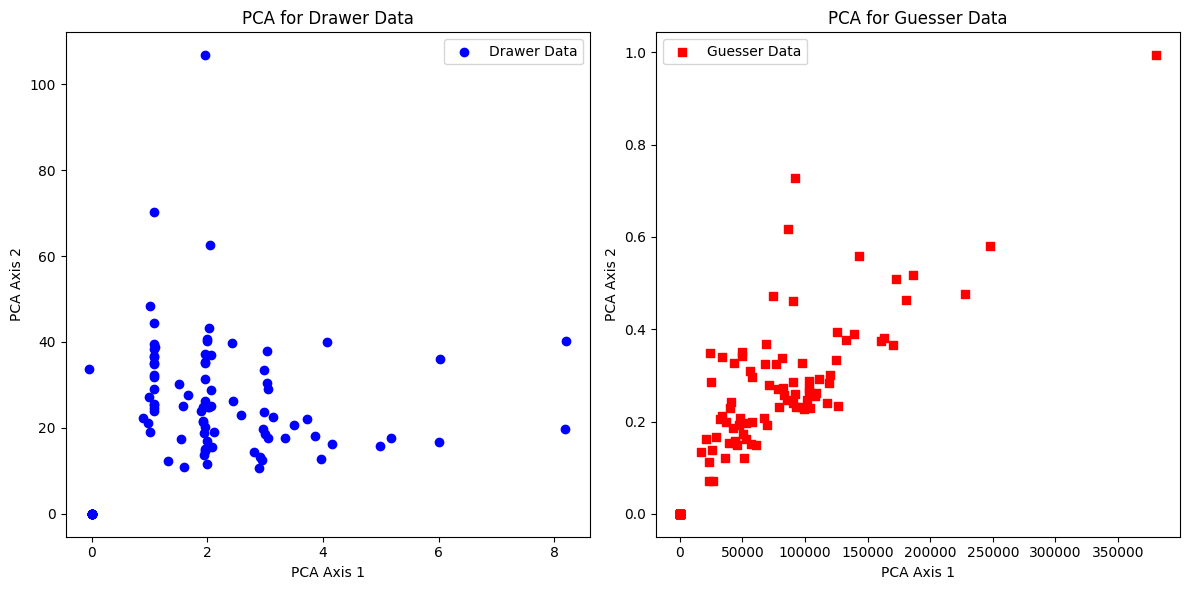

In [12]:
# 1.2

# 1.2.1
import pandas as pd
drawer = pd.read_csv('drawer_attributes.csv')
guesser = pd.read_csv('guesser_attributes.csv')
# values
drawer = drawer.values
guesser = guesser.values

# remove column 1 of ids
drawer = drawer[:, 1:]
guesser = guesser[:, 1:]

drawer_pcs = 5
guesser_pcs = 5

pca4 = PCA()
pca4.fit(drawer)
guesser_reduced = pca4.get_transform(drawer_pcs)

pca5 = PCA()
pca5.fit(guesser)
drawer_reduced = pca5.get_transform(guesser_pcs)

plt.figure(figsize=(12, 6))

# Drawer
plt.subplot(121)
plt.scatter(drawer_reduced[:, 0], drawer_reduced[:, 1], c='b', marker='o', label='Drawer Data')
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.title('PCA for Drawer Data')
plt.legend()

# Guesser
plt.subplot(122)
plt.scatter(guesser_reduced[:, 0], guesser_reduced[:, 1], c='r', marker='s', label='Guesser Data')
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.title('PCA for Guesser Data')
plt.legend()

plt.tight_layout()
plt.show()

## 1.2.2
### What does each of the new axes that are obtained from PCA represent?

1. **PC1 (First Principal Component):** Represents the dominant pattern in the data, capturing the most variance.
2. **PC2 (Second Principal Component):** Represents a pattern orthogonal to PC1, capturing the second most variance and often revealing a different aspect of the data.
3. **Subsequent PCs (PC3, PC4, etc.):** Capture diminishing amounts of variance and represent additional orthogonal patterns or variations in the data.
